In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

# Define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1133)>



100%|██████████| 9912422/9912422 [00:08<00:00, 1164111.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1133)>



100%|██████████| 28881/28881 [00:00<00:00, 196498.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1133)>



100%|██████████| 1648877/1648877 [00:07<00:00, 208092.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1133)>



100%|██████████| 4542/4542 [00:00<00:00, 970875.99it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [ ]:
subset_size = 10000  # Use 10,000 images instead of 60,000
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = Subset(train_dataset, indices)

In [6]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# Plot the confusion matrix for MLP
def plot_confusion_matrix(mlp_cm, model_used):
    plt.figure(figsize=(8, 6))
    sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix for {model_used} on MNIST")
    plt.show()

In [7]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 30)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(30, 20)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_features(self, x):
        """Get the output from the second hidden layer (20 neurons)"""
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return x

In [11]:
# Initialize the MLP model
mlp_model = MLP().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

In [14]:
num_epochs = 100
mlp_model.train()
for epoch in range(1, num_epochs+1):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0135
Epoch [20/100], Loss: 0.0124
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0028
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0006
Epoch [100/100], Loss: 0.0000


In [17]:
# Evaluation on test data
mlp_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

MLP F1-score: 0.9645
MLP Confusion Matrix:


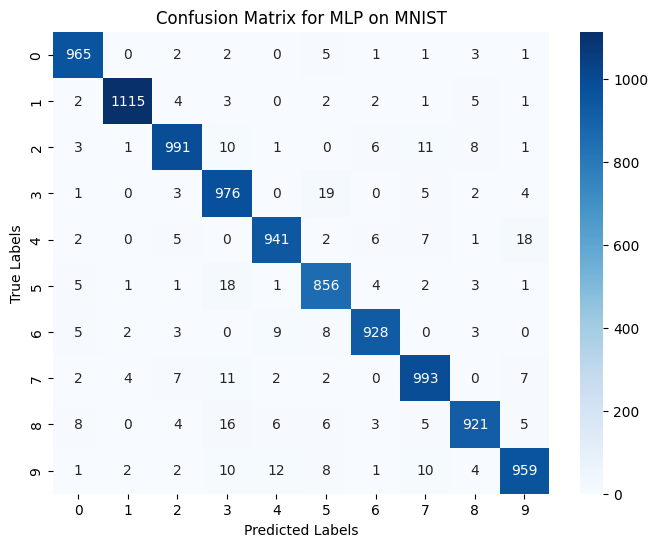

In [21]:
# Compute F1-score and confusion matrix for MLP
mlp_f1 = f1_score(all_labels, all_preds, average='weighted')
mlp_cm = confusion_matrix(all_labels, all_preds)
print(f'MLP F1-score: {mlp_f1:.4f}')
print('MLP Confusion Matrix:')
plot_confusion_matrix(mlp_cm, 'MLP')

Random Forest F1-score: 0.9525
Random Forest Confusion Matrix:


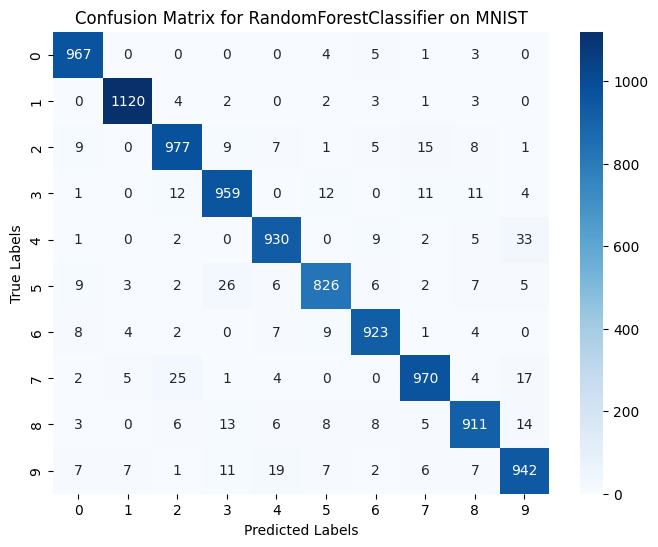

In [23]:
# Train Random Forest Classifier
# Flatten the images for scikit-learn models
train_images = train_dataset.data.numpy().reshape(-1, 28*28)
train_labels = train_dataset.targets.numpy()
test_images  = test_dataset.data.numpy().reshape(-1, 28*28)
test_labels  = test_dataset.targets.numpy()

# Use a subset 
rf_subset_size = 10000
rf_indices = np.random.choice(len(train_images), rf_subset_size, replace=False)
rf_train_images = train_images[rf_indices]
rf_train_labels = train_labels[rf_indices]

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(rf_train_images, rf_train_labels)
rf_preds = rf_model.predict(test_images)
rf_f1 = f1_score(test_labels, rf_preds, average='weighted')
rf_cm = confusion_matrix(test_labels, rf_preds)
print(f'Random Forest F1-score: {rf_f1:.4f}')
print('Random Forest Confusion Matrix:')
plot_confusion_matrix(rf_cm, 'RandomForestClassifier')


Logistic Regression F1-score: 0.8634
Logistic Regression Confusion Matrix:


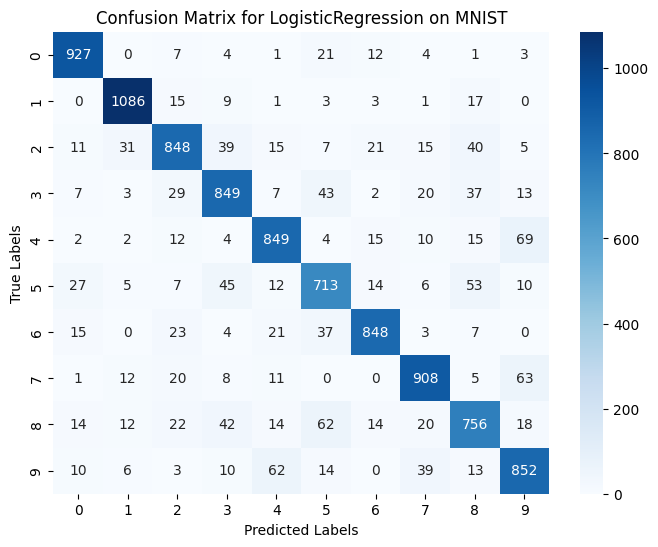

Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.93      0.97      0.95      1010
           4       0.97      0.96      0.96       982
           5       0.94      0.96      0.95       892
           6       0.98      0.97      0.97       958
           7       0.96      0.97      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [25]:
# Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(rf_train_images, rf_train_labels)
lr_preds = lr_model.predict(test_images)
lr_f1 = f1_score(test_labels, lr_preds, average='weighted')
lr_cm = confusion_matrix(test_labels, lr_preds)
print(f'Logistic Regression F1-score: {lr_f1:.4f}')
print('Logistic Regression Confusion Matrix:')
plot_confusion_matrix(lr_cm, 'LogisticRegression')

# Observations on commonly confused digits
print('Classification Report for MLP:')
print(classification_report(all_labels, all_preds))


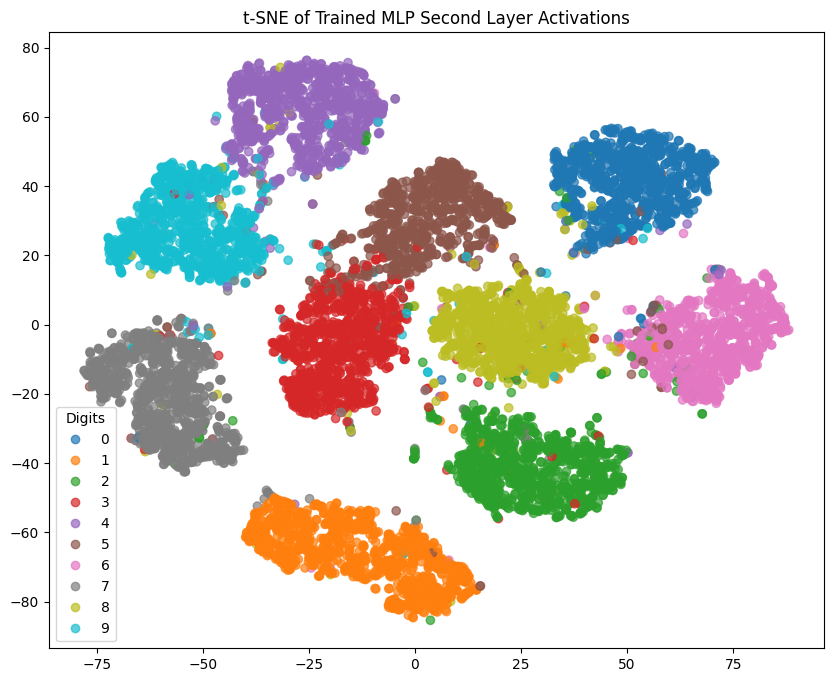

In [28]:
# t-SNE visualization for trained MLP
# Get activations from the second hidden layer for test data
mlp_model.eval()
features = []
labels_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        feats = mlp_model.get_features(images)
        features.append(feats.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
features = np.vstack(features)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title('t-SNE of Trained MLP Second Layer Activations')
plt.show()

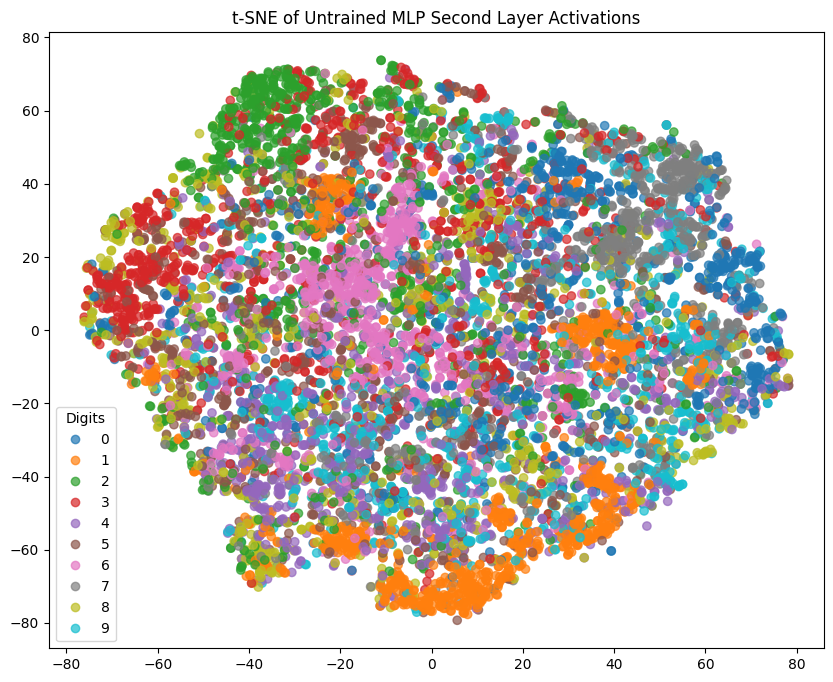

In [29]:
# t-SNE visualization for untrained MLP
# Initialize a new MLP without training
untrained_mlp = MLP()
untrained_mlp.eval()
untrained_features = []
with torch.no_grad():
    for images, _ in test_loader:
        feats = untrained_mlp.get_features(images)
        untrained_features.append(feats.numpy())
untrained_features = np.vstack(untrained_features)

# Perform t-SNE
untrained_tsne = tsne.fit_transform(untrained_features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(untrained_tsne[:, 0], untrained_tsne[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title('t-SNE of Untrained MLP Second Layer Activations')
plt.show()

In [31]:
# Use the trained MLP to predict on Fashion-MNIST dataset
fashion_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_loader  = DataLoader(fashion_dataset, batch_size=batch_size, shuffle=False)



Fashion-MNIST F1-score with MNIST-trained MLP: 0.0538


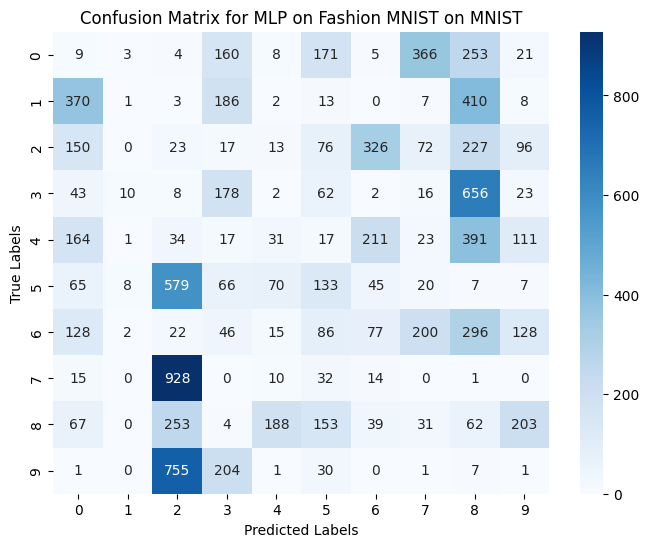

In [36]:
# Get predictions
fashion_preds = []
fashion_labels = []
fashion_features = []
with torch.no_grad():
    for images, labels in fashion_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        fashion_preds.extend(predicted.cpu().numpy())
        fashion_labels.extend(labels.cpu().numpy())
        feats = mlp_model.get_features(images)
        fashion_features.append(feats.cpu().numpy())
fashion_features = np.vstack(fashion_features)

# Observations on Fashion-MNIST predictions
fashion_f1 = f1_score(fashion_labels, fashion_preds, average='weighted', zero_division=0)
fashion_cm = confusion_matrix(fashion_labels, fashion_preds)
print(f'Fashion-MNIST F1-score with MNIST-trained MLP: {fashion_f1:.4f}')
plot_confusion_matrix(fashion_cm, 'MLP on Fashion MNIST')


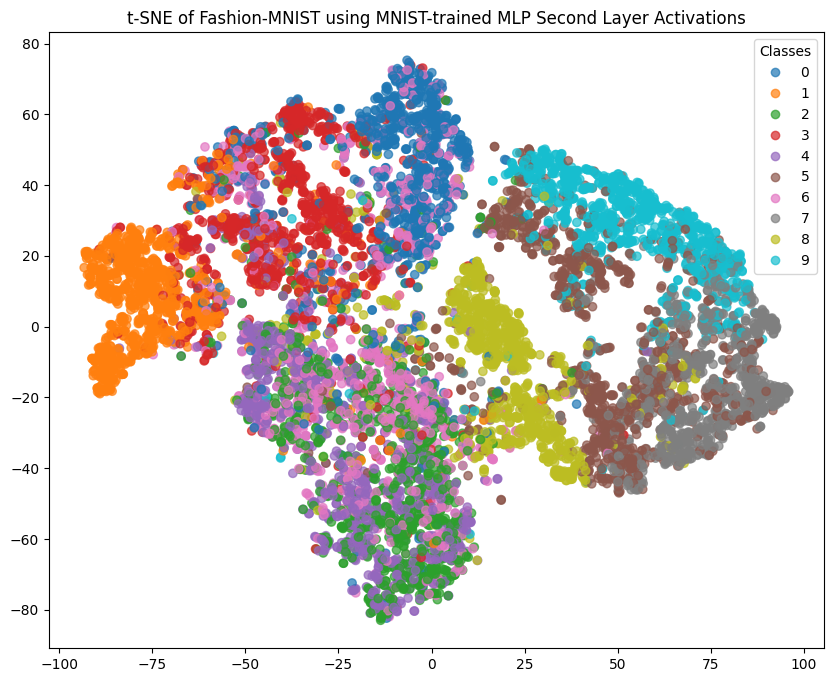

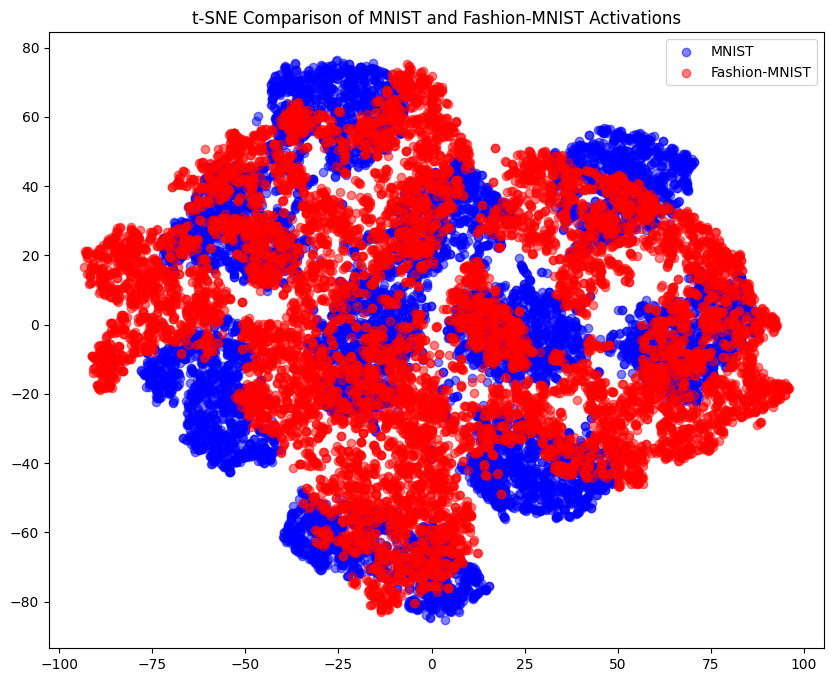

In [35]:
# t-SNE visualization for Fashion-MNIST
fashion_tsne = tsne.fit_transform(fashion_features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(fashion_tsne[:, 0], fashion_tsne[:, 1], c=fashion_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE of Fashion-MNIST using MNIST-trained MLP Second Layer Activations')
plt.show()

# Compare embeddings between MNIST and Fashion-MNIST
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c='blue', alpha=0.5, label='MNIST')
plt.scatter(fashion_tsne[:, 0], fashion_tsne[:, 1], c='red', alpha=0.5, label='Fashion-MNIST')
plt.legend()
plt.title('t-SNE Comparison of MNIST and Fashion-MNIST Activations')
plt.show()